In [ ]:
# Metrics learning. Практика.

Необходимо кластеризовать клиентов банка по характеру финансового поведения с продуктом банка (кредитная карта). 

## Описание данных:

CUSTID: Идентификационный номер держателя карты

BALANCE: Доступный для трат баланс

BALANCEFREQUENCY: Признак, показывающий как часто обновляется баланс, изменяется от 0 (никогда не обновляется) до 1 (очень часто обновляется)

PURCHASES: Количество покупок сделанное с карты

ONEOFFPURCHASES: Максимально поличество покупок «за раз»

INSTALLMENTSPURCHASES: Сумма покупок в рассрочку

CASHADVANCE: Сумма овердрафта

PURCHASESFREQUENCY: Признак, показывающий как часто делаются покупки с карты, изменяется от 0 (никогда не используется) до 1 (постоянно используется)

ONEOFFPURCHASESFREQUENCY: Признак, показывающий как часто Покупки происходят за один раз, изменяется от 0 (редко покупаются) до 1 (часто покупаются)

PURCHASESINSTALLMENTSFREQUENCY: Признак, показывающий как часто Покупки происходят в рассрочку, изменяется от 0 (редко покупаются) до 1 (часто покупаются)

CASHADVANCEFREQUENCY: Как часто платится овердрафтом

CASHADVANCETRX: Количество оплат в овердрафте

PURCHASESTRX: Количество транзакций покупок

CREDITLIMIT: Лимит кредита по карте

PAYMENTS: Задолженность по карте

MINIMUM_PAYMENTS: Минимальный платеж по задолженности

PRCFULLPAYMENT: Платеж для беспроцентного периода

TENURE: Стоимость обслуживания карты

## Загрузим необходимые данные и библиотеки

In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")

In [28]:
# посмотрим на данные
data= pd.read_csv("data/CC GENERAL.csv")
print(data.shape)
data.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Обработка данных

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Посмотрим на статистики.

In [29]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Работа с пропусками

In [33]:
print('Количество пропусков:', data['MINIMUM_PAYMENTS'].isnull().sum())
print('Доля пропусков:', round(data['MINIMUM_PAYMENTS'].isnull().mean(), 2))

Количество пропусков: 313
Доля пропусков: 0.03


Заполним значения `MINIMUM_PAYMENTS`, `CREDIT_LIMIT` средним значением:

In [34]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']= data['CREDIT_LIMIT'].mean()

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA


## Работа с выбросами

Для работы с выбросами сделаем диапазоновые значения признаков, для этого будем использовать функцию

In [36]:
def add_range(df, columns, range_list, onesided = True):
    for column in columns:
        name = column + '_range'
        df[name] = 0
        for i in range(len(range_list)-1):
            df.loc[(df[column] > range_list[i])&(df[column] <= range_list[i+1]), name] = i+1
            if onesided:
                df.loc[(df[column] >range_list[-1]), name] = len(range_list)
    df.drop(columns, axis = 1, inplace = True)

In [37]:
add_range(data,['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS'], [0,500,1000,3000,5000,10000])

In [38]:
add_range(data,['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'] , np.linspace(0,1,11),onesided=False)

In [39]:
add_range(data,['PURCHASES_TRX', 'CASH_ADVANCE_TRX'] ,[0,5,10,15,20,30,50,100] ,onesided=False)

In [40]:
data.drop(['CUST_ID'], axis=1, inplace=True)

X= np.asarray(data)

### Стандартизация данных

In [41]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

Определимся с количеством кластеров

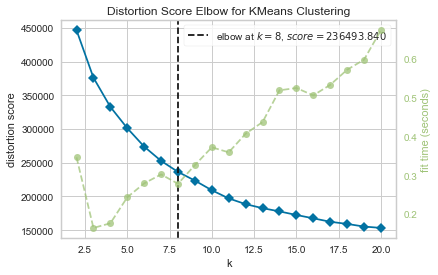

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=20) 
Elbow_M.fit(data)
Elbow_M.show()

Оптимальное количество кластеров - 8. Сохраним его в переменную:

In [43]:
k_clust = 8

## Кластеризация

Обучим модель KMeans с 8 кластерами

In [44]:
kmean= KMeans(k_clust)
kmean.fit(X) 
labels=kmean.labels_

In [45]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,5
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,2
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,6
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,6
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,5


## Анализ результатов кластеризации

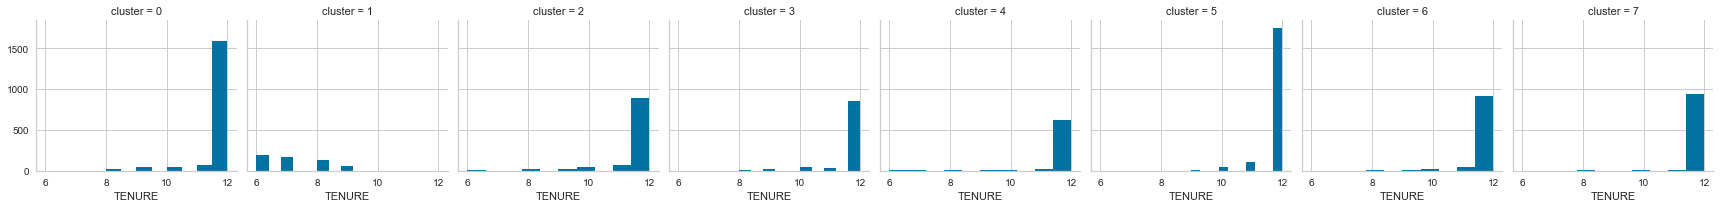

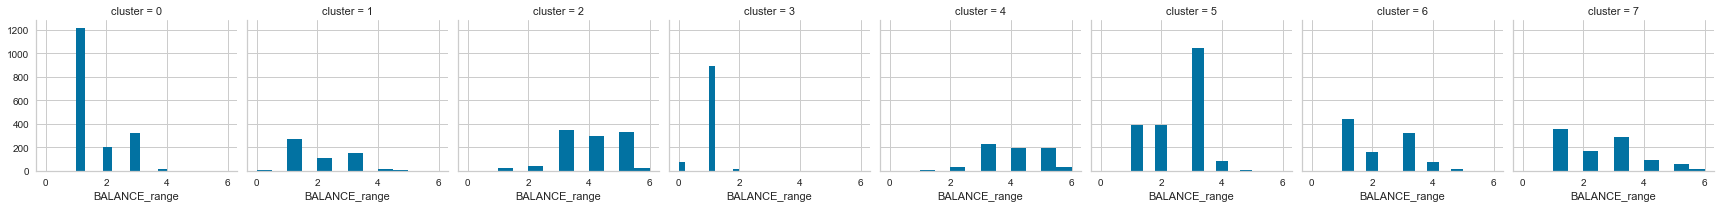

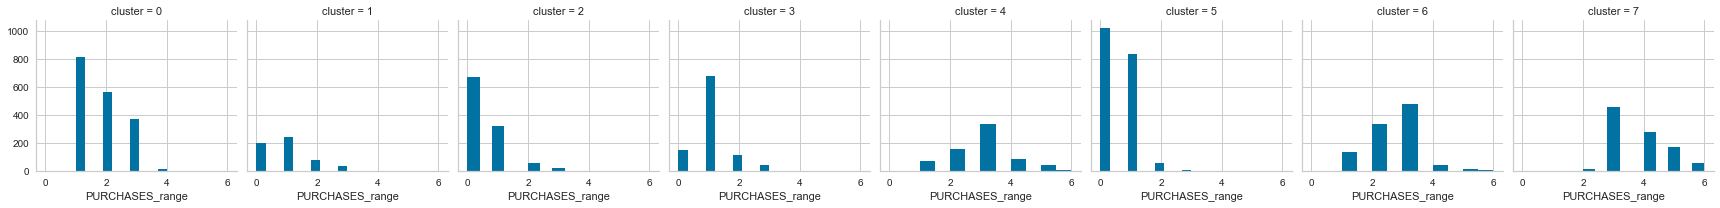

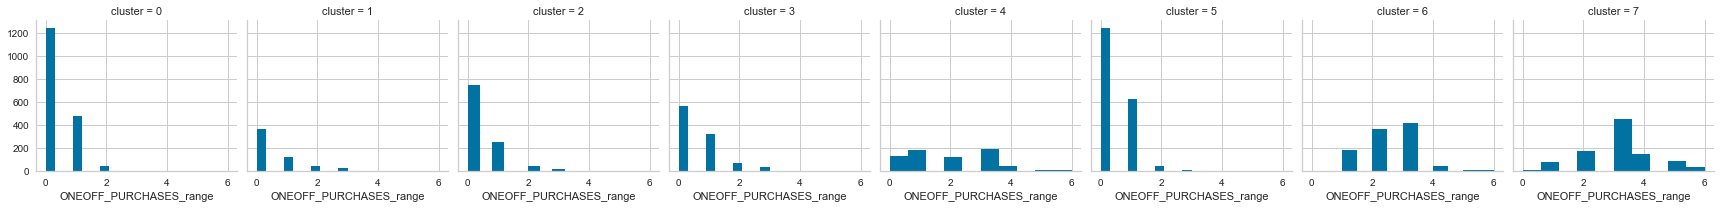

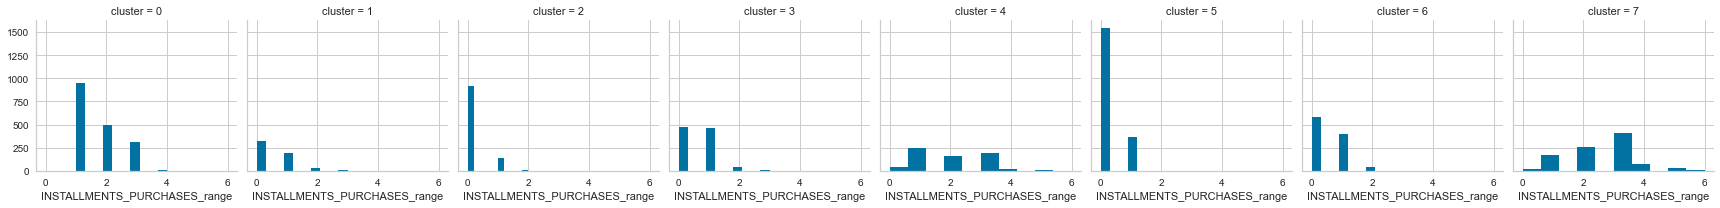

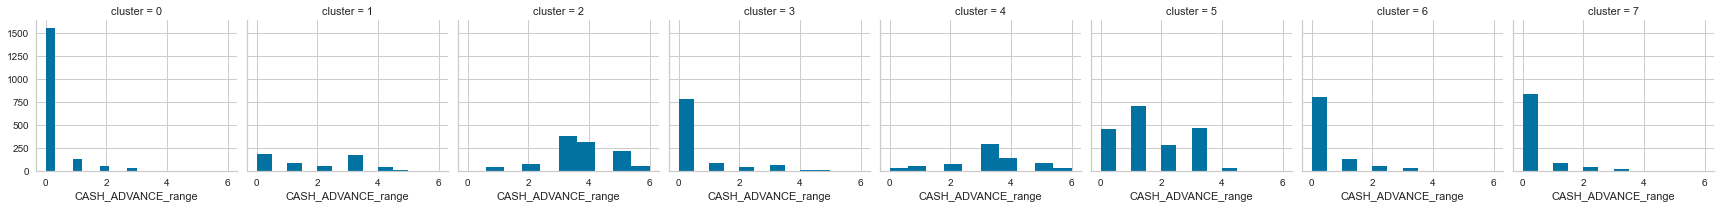

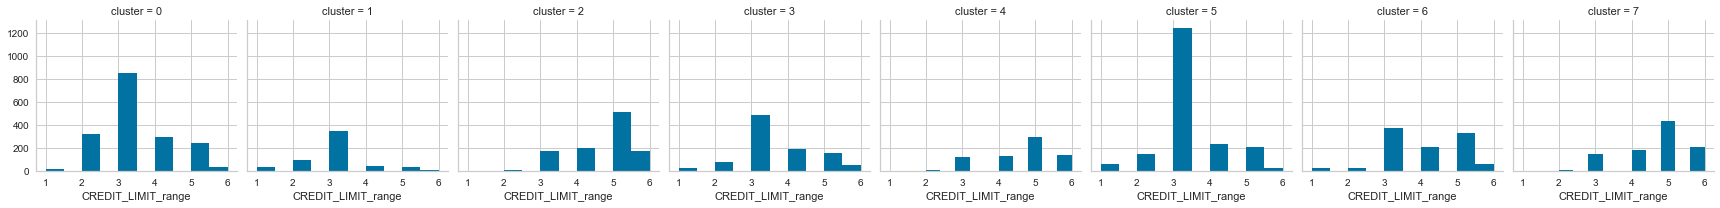

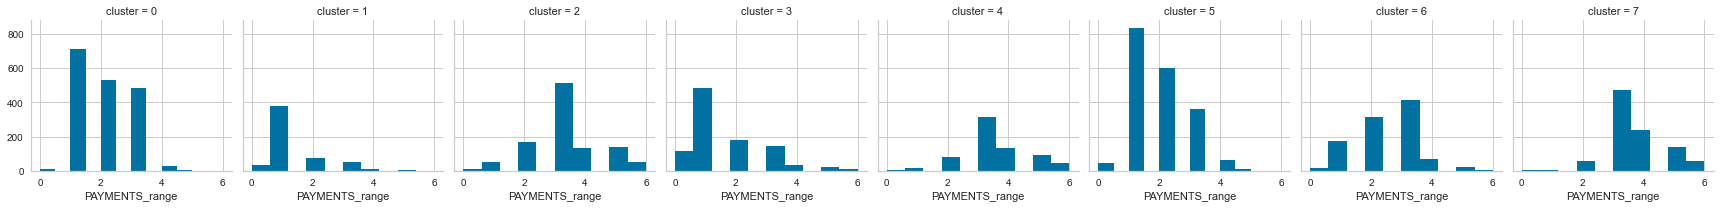

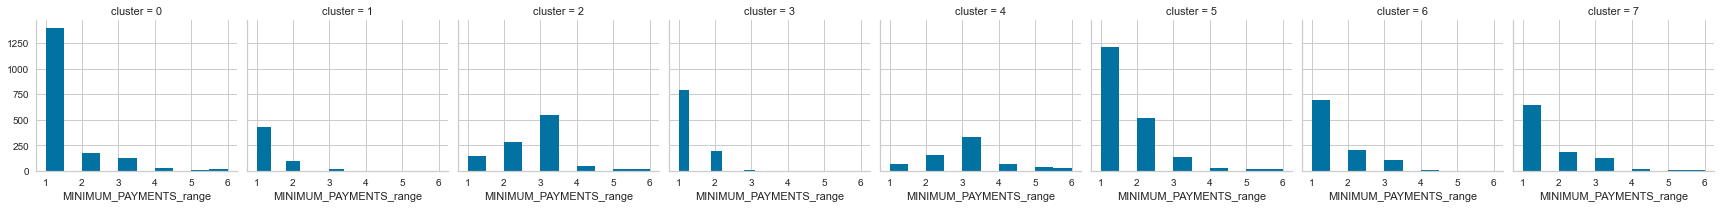

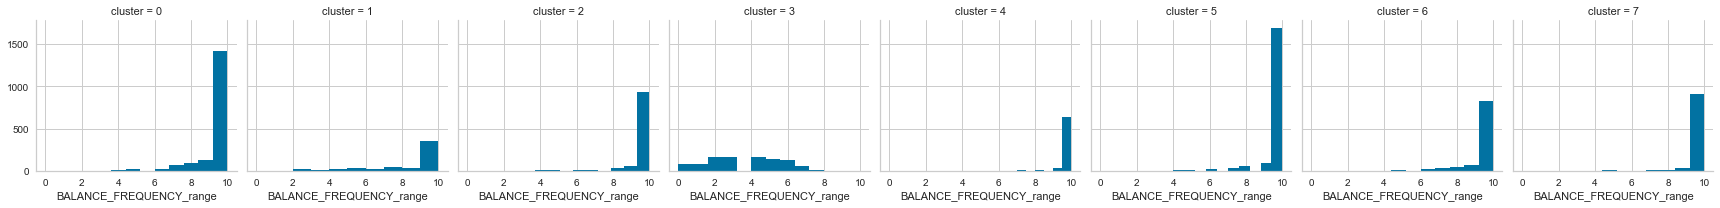

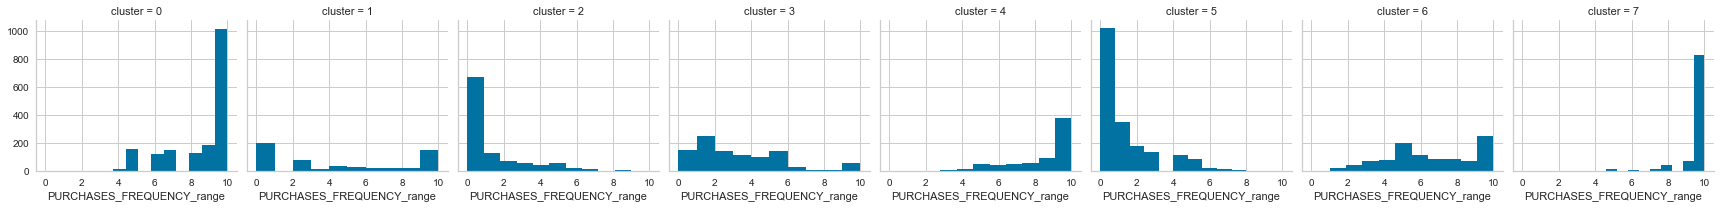

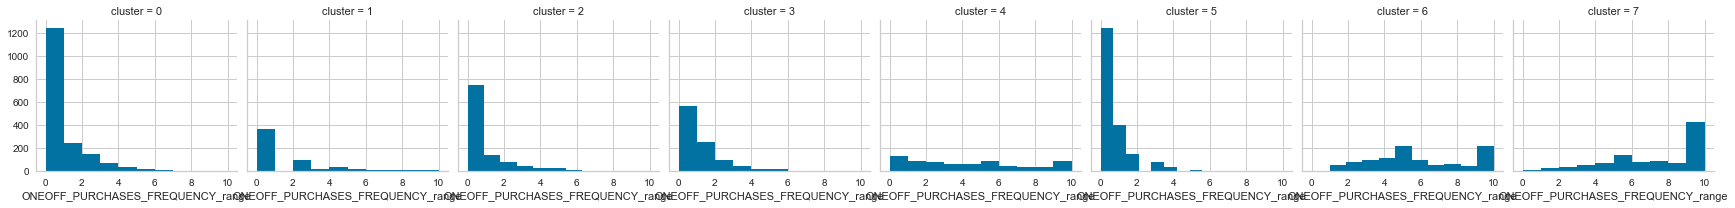

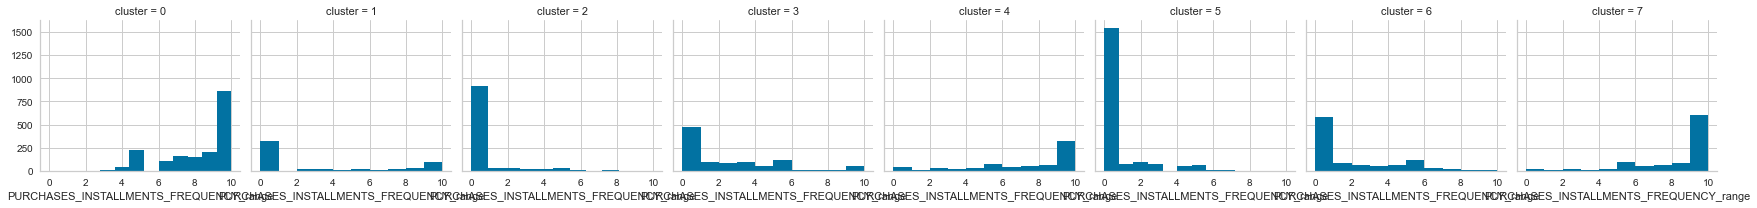

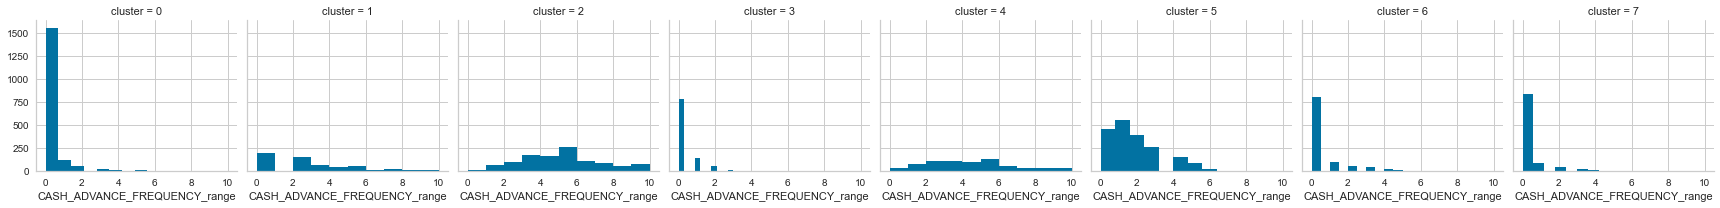

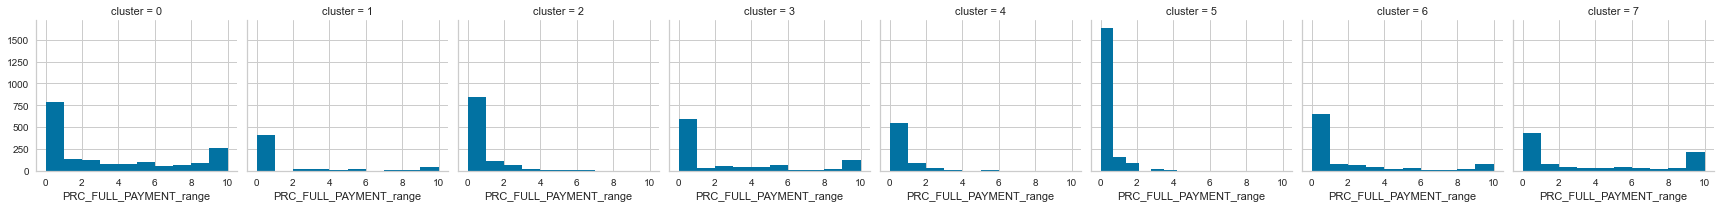

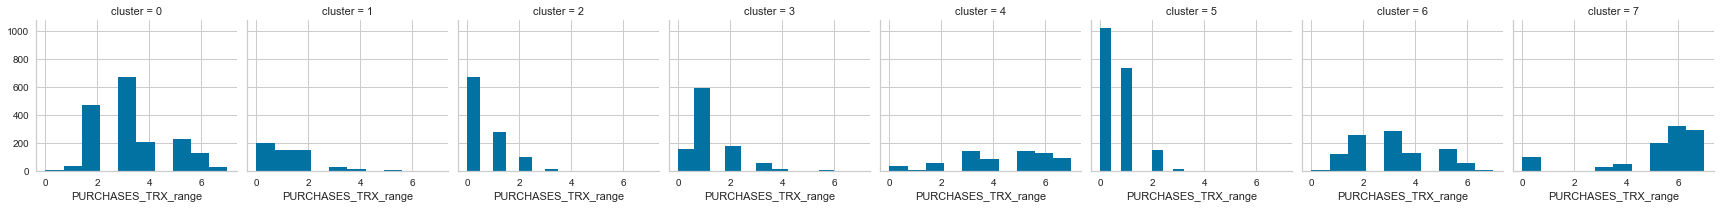

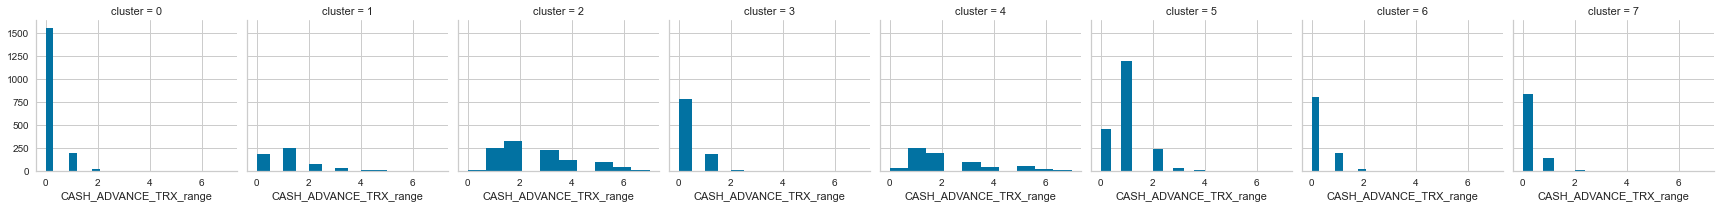

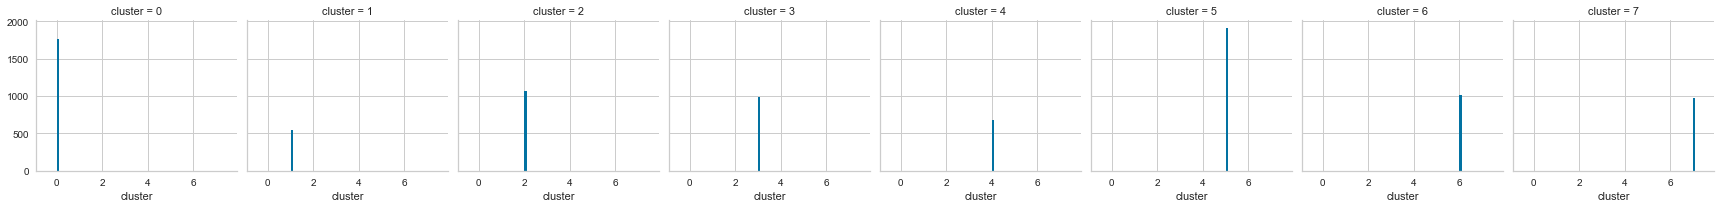

In [46]:
for c in clusters: # для каждого кластера
    grid= sns.FacetGrid(clusters, col='cluster') # отобразим распределние по признакам
    grid.map(plt.hist, c) # на гистограммах

Выводы:

Группа 0: в основном маленькие суммы на балансе; очень частые покупки по карте, но недорогие, чаще по 1 товару в чеке, практически всегда в рассрочку; средний кредитный лимит, средняя задолженность по картам, которая покрывается минимальными платежами; овердрафт не используется.

Группа 1: небольшие суммы на балансе; покупки по картам делаются редко, очень мало, по 1 товару за раз, без использования рассрочки; маленький кредитный лимит, маленькая задолженность, выплачивается минимальными платежами; овердрафт используется редко.

Группа 2: средние и достаточно большие суммы на балансе; покупки совершаются редко, по 1 товару в чеке, без использования рассрочки; кредитный лимит высокий, задолженоость средняя, часто используется досрочное погашение; овердрафт используется редко.

Кластер 3: маленькие суммы на балансе (практически не меняется в отличие от других кластеров, где часто меняется количество денег на счетах); редкие покупки в малом количестве, иногда в рассрочку; средний кредитный лимит, небольшие задолженности, минимальные платежи; овердрафт не используется.

Кластер 4: средние и большие суммы на счетах, 